# Lab 5

This lab extends binary logistic regression to [multi-class logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression), which goes by a variety of names, including *softmax regression*, due to the use of the softmax function, which generalizes the logistic function.

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

We again load the Fashion MNIST dataset, though this time around, we'll use all 10 output classes.

In [2]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
# The label for X_train[0] is in Y_train[0].
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

### Cross-Entropy Loss

Recall the log loss function (also called binary cross-entropy):

\begin{equation}
-y log(\hat{y}) + (1−y)log(1−\hat{y})
\end{equation}

In the above formulation, it is assumed that $y$ is either 0 or 1, so either the left term or the right term is active for each example.

The general form for cross-entropy is used when $y$ is assumed to be a label vector with a 1 in the index of the true label and a 0 everywhere else: $y=[0,0,0,0,0,0,0,1,0,0]$ implies a label of "sneaker" in this dataset (the 7th label). Accordingly, $\hat{y}$ is a vector of predicted probabilities. Then the cross-entropy loss is simply:

\begin{equation}
-\sum_{j} y_j log(\hat{y}_j)
\end{equation}

As in the binary case, this summation will have exactly 1 non-zero term where the true label $y_j=1$.

Note that this formulation is using a *dense* representation of the label. The corresponding *sparse* representation would use the non-zero index directly ($y=7$).

## Build a model

Let's construct a model much like we did in the binary classification case, but now with a multi-class output.

---
### Exercise 1 (8 points)

Fill in the NotImplemented parts of the build_model function below. You will need to make the following changes to generalize the binary case to the multi-class case:
* The output will include 10 probabilities instead of 1.
* Use a softmax function instead of a sigmoid.
* Use a [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) loss instead of binary_crossentropy. Note that "sparse" refers to the use of a sparse index (e.g. 7) to indicate the label rather than a dense vector (e.g. [0,0,0,0,0,0,0,1,0,0]).

Check that training works below.

In [3]:
def build_model(n_classes, learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
      # YOUR CODE HERE
      units=10,
      activation='softmax' # use softmax 
    ))

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # YOUR CODE HERE
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
    return model

---

Make sure your model trains. If you configured it properly, the training loss should get to ~0.55 after 5 epochs.

In [4]:
model = build_model(len(label_names), 0.01)

history = model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
114/844 [===>..........................] - ETA: 0s - loss: 1.6713 - accuracy: 0.5023  

2022-09-22 09:16:20.132922: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


844/844 [==============================] - 1s 540us/step - loss: 0.9976 - accuracy: 0.6943 - val_loss: 0.7644 - val_accuracy: 0.7502
Epoch 2/5
844/844 [==============================] - 0s 453us/step - loss: 0.6845 - accuracy: 0.7816 - val_loss: 0.6679 - val_accuracy: 0.7762
Epoch 3/5
844/844 [==============================] - 0s 448us/step - loss: 0.6161 - accuracy: 0.8030 - val_loss: 0.6231 - val_accuracy: 0.7885
Epoch 4/5
844/844 [==============================] - 0s 461us/step - loss: 0.5787 - accuracy: 0.8139 - val_loss: 0.5986 - val_accuracy: 0.7980
Epoch 5/5
844/844 [==============================] - 0s 473us/step - loss: 0.5544 - accuracy: 0.8201 - val_loss: 0.5761 - val_accuracy: 0.8060


,loss,accuracy,val_loss,val_accuracy
0,0.997606,0.694278,0.764360,0.750167
1,0.684474,0.781648,0.667892,0.776167
2,0.616129,0.802981,0.623094,0.788500
3,0.578731,0.813926,0.598561,0.798000
4,0.554377,0.820130,0.576119,0.806000


### Evaluation Metrics

Classification metrics like accuracy, precision, and recall can all be derived from a confusion matrix which displays the counts for all pairs of true label and predicted label. Correct predictions are on the diagonal and incorrect predictions (confusions) are off the diagonal.

First, we need the predicted labels from the model.

In [5]:
# Recall that model.predict gives a vector of probabilities for each x.
# Get labels by taking the argmax -- the index with the largest probability.
test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(test_predictions)

313/313 [==============================] - 0s 278us/step
[9 2 1 ... 8 1 5]


Next, we create a confusion matrix and produce an easy-to-read visualization.

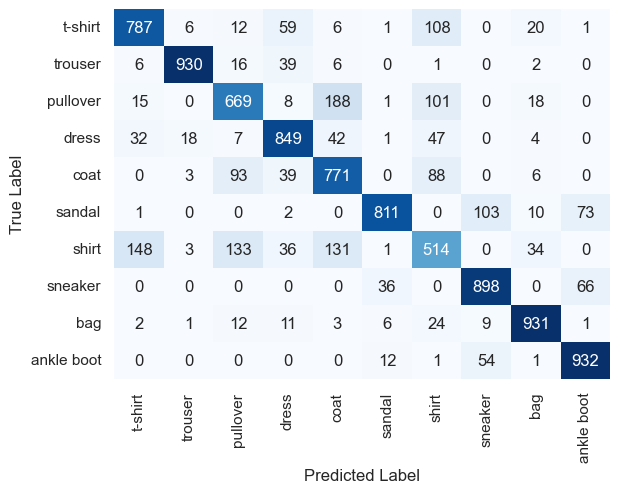

In [6]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [7]:
# convert to numpy
p = confusion_matrix.numpy()

# find the matrix diagnoal then find min and max
diag_min = np.min(np.diagonal(confusion_matrix))
diag_max = np.max(np.diagonal(confusion_matrix))

# find the indices of min and max element. the results are tuples
indices_min = np.where(p == diag_min)
indices_max = np.where(p == diag_max)

# calculate precision for min and max
precision_min = p[indices_min[0], indices_min[1]] / np.sum(p[:, indices_min[1]])
precision_max = p[indices_max[0], indices_max[1]] / np.sum(p[:, indices_max[1]])

# print results, fetch label using indices then get the value.
print(f'The {label_names[indices_min[0][0]]} has the lowest precision {precision_min}')
print(f'The {label_names[indices_max[0][0]]} has the highest precision {precision_max}')

The shirt has the lowest precision [0.58144796]
The ankle boot has the highest precision [0.86859273]


In [8]:
# sneaker_indices = label_names.index('sneaker')
# FP_array = p[:, sneaker_indices ]
# FP_array_max

# FN_array = p[sneaker_indices, : ]
# FN_array

---
### Exercise 2 (8 points)

Answer the following questions by studying the confusion matrix (above).

1. Which class has the lowest precision? What is that precision? Which class has the highest precision? What is that precision?

2. For the class 'sneaker', what class is the largest source of false negatives? What about the largest source of false positives?

*Written answer:*

1. 
    The (shirt) has the lowest precision [0.58144796] ***
    The (ankle) boot has the highest precision [0.86859273]



2.  
    The largest source of false negatives is (Ankel boots) ***
    The largest false possitive class is (Sandal)
    


---

## Analyze Errors

A crucial part of the development cycle in Machine Learning is analyzing errors to help understand the shortcomings of the model. While typically we'd want to use the development data for this purpose to preserve the purity of the test set, we'll just use our test split for simplicity.

Since the "shirt" class seems to be the source for a lot of errors, let's look at some of the confusions.

---
### Exercise 3 (8 points)

1. Display 5 images with true label "shirt", but predicted label "coat" (false negatives for the "shirt" class).
2. Display 5 images with predicted label "shirt", but true label "coat" (false positives for the "shirt" class).

In [9]:
# YOUR CODE HERE
# find the true coat, predicted coat, true shirt, predicted shirt positions
true_coat_positions = np.where(Y_test == 4)
test_coat_positions = np.where(test_predictions == 4)
true_shirt_positions = np.where(Y_test == 6)
test_shirt_positions = np.where(test_predictions == 6)

# find the true shirt but test predicted as coat (false negatives) 
# by using intersect this will result in 131 indices
FN_shirt_coat = np.intersect1d(true_shirt_positions, test_coat_positions, assume_unique = True)
print('Fales Negative: predicted as a coat but it is a shirt', FN_shirt_coat)

# find the actual true coat but predicted as shirt (false positive)
FP_shirt_coat = np.intersect1d(true_coat_positions, test_shirt_positions, assume_unique = True)
print('False Positive: predicted as shirt but is a coat ', FP_shirt_coat)


Fales Negative: predicted as a coat but it is a shirt [ 101  117  135  241  252  406  444  548  587  634  664  725  767  823
  921  963 1025 1046 1058 1131 1162 1174 1241 1253 1277 1502 1620 1643
 1701 1922 2110 2137 2145 2162 2300 2540 2622 2694 2754 2842 2942 3239
 3262 3338 3545 3548 3613 3658 3669 3799 3861 3926 3987 4079 4152 4585
 4645 4677 4817 5004 5040 5052 5096 5161 5168 5197 5452 5497 5596 5682
 5749 5795 5826 5885 5889 5917 5983 6002 6156 6160 6254 6379 6407 6452
 6512 6531 6539 6540 6626 6640 7004 7024 7030 7040 7094 7111 7188 7221
 7258 7262 7527 7764 7812 7962 7992 8005 8082 8106 8202 8260 8269 8288
 8438 8490 8518 8633 8658 8749 8784 8918 8940 8946 9025 9157 9188 9280
 9487 9495 9513 9684 9904]
False Positive: predicted as shirt but is a coat  [  50   98  150  151  313  324  396  475  526  907  935  994 1055 1065
 1101 1104 1377 1388 1811 1848 1879 1911 2139 2144 2150 2284 2376 2462
 2487 2617 2776 2919 3176 3479 3617 3731 3804 4251 4510 4608 4639 4739
 4775 4922 5167 5

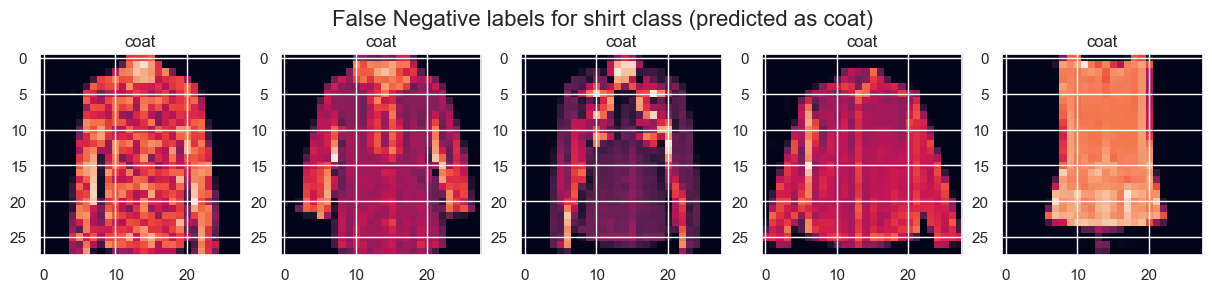

In [10]:
# create figure which will have 1X5 subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,3))
fig.suptitle('False Negative labels for shirt class (predicted as coat)', fontsize=16)
# print False Negative true shirt/predicted coat images
for i in range(5):
    # get the postion 
    position = FN_shirt_coat[i]
    # get the label
    label_name = label_names[test_predictions[position]]
    # axs1[i].imshow(X_test[position], cmap='gray')
    axs[i].imshow(X_test[position])
    axs[i].set_title(label_name)
# fig.suptitle('False Negative labels for shirt class ', fontsize=16)
plt.show()

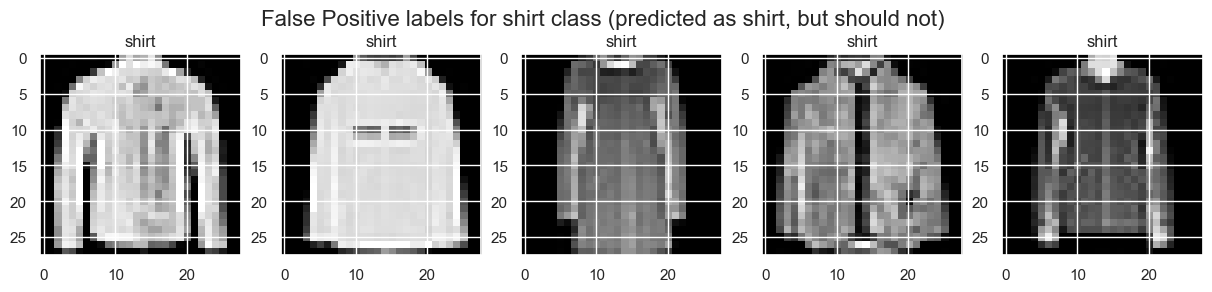

In [11]:
# create figure which will have 1X5 subplots
fig1, axs1 = plt.subplots(nrows=1, ncols=5, figsize=(15,3))
fig1.suptitle('False Positive labels for shirt class (predicted as shirt, but should not)', fontsize=16)
# print False Positive true coat/predicted shirt images
for i in range(5):
    # get the postion 
    position = FP_shirt_coat[i]
    # get the label
    label_name = label_names[test_predictions[position]]
    axs1[i].imshow(X_test[position], cmap='gray')
    # axs1[i].imshow(X_test[position])
    axs1[i].set_title(label_name)

plt.show()

In [12]:
# very combersome way to find the FN
# Step 1: 
# find the true label for shirt (class = 6) indices. 
# the result is a tuple which has one array element which contains
# the indices. In this case should be 1000
Y_test_shirt_indices = np.where(Y_test == 6)

# Step 2:
# need to extract the indices where test predicted as coat (class = 4)
# but the true label index is a shirt (class = 6)
# find the test_predictions label valus using true label indices
# this will find all 1000 predicted class labels which will have shirt
# and coats and other classes
# count the total number of coats which should have been shirts (131)
# total_FN_coats = len(Y_test_shirt_pred_values[Y_test_shirt_pred == 4 ])
Y_test_shirt_pred_values = test_predictions[Y_test_shirt_indices]

# Step 3:
# find the positions of coats (class = 4) within Y_test_shirt_pred_values
test_coat_positions = np.where(Y_test_shirt_pred_values == 4 )

# Step 4:
# store the first 5 positions to be used to locate 
# the actual positions in the X_test dataset
# Y_test_shirt_indices[0][FN_shirt_positions[4]]
FN_shirt_positions = test_coat_positions[0][0:5]

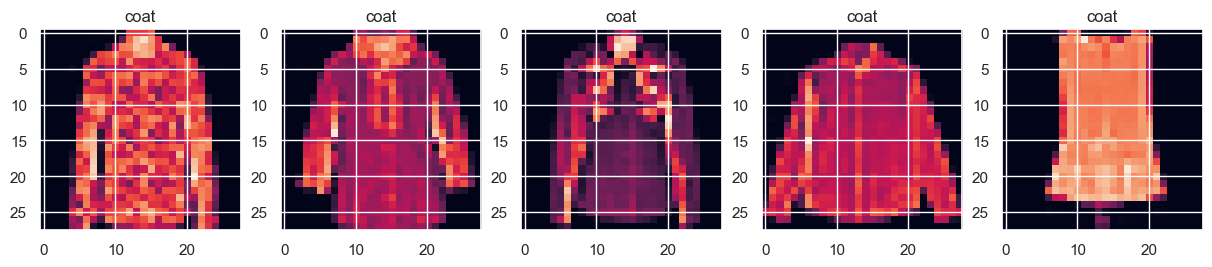

In [13]:
# create figure which will have 1X5 subplots
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,40))

# print images
for i in range(5):
    # get the postion from true label indices
    position = Y_test_shirt_indices[0][FN_shirt_positions[i]]
    # get the label
    label_name = label_names[test_predictions[position]]
    # axs[i][j].imshow(image[j], cmap='gray')
    axs[i].imshow(X_test[position])
    axs[i].set_title(label_name)


plt.show()

---

## Visualize Parameters
Finally, here's some code that helps visualize the learned parameters for each class.

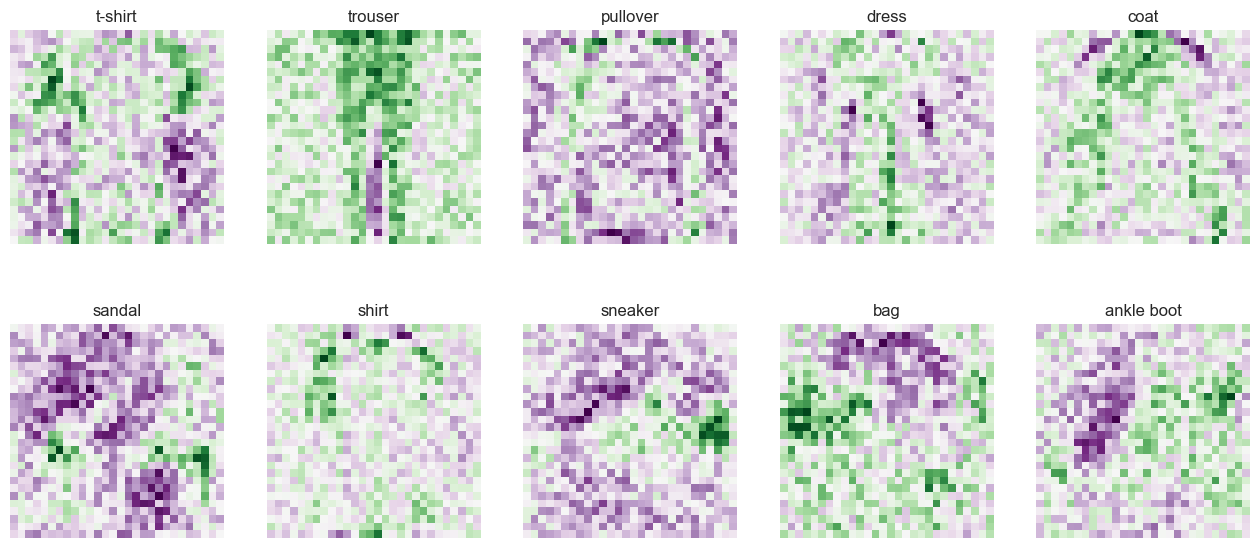

In [14]:
weights, biases = model.layers[1].get_weights()
fig, axs = plt.subplots(2, 5, figsize=(16,7))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(weights[:,i].reshape(28,28), cmap='PRGn')
  ax.axis('off')
  ax.set_title(label_names[i])
plt.show()